In [6]:
from dotenv import load_dotenv
import anthropic
import os
import json
import networkx as nx
import matplotlib.pyplot as plt

In [7]:
system_prompt_path = r'..\live_conversational_threads\system_prompt.txt'
transcript_path = r'..\live_conversational_threads\transcript.txt'

with open(system_prompt_path, 'r') as f:
    system_prompt = f.read()

with open(transcript_path, 'r') as f:
    transcript = f.read()

In [8]:
transcript

'Maya: Hey Liam, did you try that new productivity app I recommended?\nLiam: Yeah, I installed it last night! It looks promising, but I haven’t explored all the features yet.\nMaya: I really like the task automation part. It helps me set reminders and track progress.\nLiam: That’s what I need. I keep forgetting small tasks. I was supposed to review my report this morning, and guess what? Totally slipped my mind.\nMaya: Ha! Been there. Speaking of which, how’s the report going?\nLiam: It’s mostly done, but I need to polish some sections.\nMaya: Want me to take a quick look?\nLiam: That’d be great. Oh wait, let me make a note of this. Lingardium bookmarkium create Report Review.\nMaya: Smart move. We’ll get back to it later.\nLiam: Yeah. Anyway, have you seen the news about that AI-powered chatbot that can simulate real conversations?\nMaya: Oh yeah, it’s wild! People are saying it might replace customer service jobs.\nLiam: I doubt it. AI is good, but it still struggles with human nuanc

In [9]:
class Node:
    def __init__(self, node_name, node_type, predecessor, successor, related_nodes, relationship_strength, summary):
        self.node_name = node_name
        self.node_type = node_type  
        self.predecessor = predecessor
        self.successor = successor
        self.related_nodes = related_nodes
        self.relationship_strength = relationship_strength
        self.summary = summary
    
    def __repr__(self):
        return f"Node({self.node_name}, {self.node_type}, {self.predecessor}, {self.successor}, {self.related_nodes}, {self.relationship_strength}, {self.summary})"

In [11]:
def generate_lct_json(transcript, temp = 0.3):
    try:
        client = anthropic.Anthropic(
            api_key=os.getenv("ANTHROPIC_API_KEY"),
        )

        message = client.messages.create(
            model="claude-3-5-sonnet-20241022",
            max_tokens=8192,
            temperature=temp,
            system="You are an advanced AI model that structures conversations into JSON-formatted nodes. Each conversational shift should be captured as a new node with defined relationships.\n\nFormatting Rules:\n\nInstructions:\nExtract Key Nodes: Identify all topic shifts in the conversation. Each topic shift forms a new \"node,\" even if the topic was discussed earlier.\n\nDefine Relationships:\n\"predecessor\" → The direct previous node.\n\"successor\" → The direct next node.\n\"related_nodes\" → Other nodes with contextual similarity. If a topic appears again later, mark the first occurrence as a strongly related node instead of merging them.\n\nInfer Relationship Strength: Assign one of the following values based on contextual relevance:\n\"strong\" – Directly related, often revisited.\n\"moderate\" – Somewhat related, but not a continuation.\n\"weak\" – Loosely connected, minimal overlap.\n“Bookmark” - Represents the “conversational_threads” nodes where the “bookmark” nodes were .\n\nStrictly Generate JSON Output: Always maintain the following structure:\n[\n {\n   \"node_name\": \"Title of the conversational thread\",\n   \"type\": \"conversational_thread\" or \"bookmark\",\n   \"predecessor\": \"Previous node name\",\n   \"successor\": \"Next node name\",\n   \"related_nodes\": [\"List of related nodes\"],\n   \"relationship_strength\": { \"related_node_name\": \"strong/moderate/weak/bookmark\" },\n   \"summary\": \"Brief description of what was discussed in this node.\"\n }\n]\n\nMaintain Chronology & Loops:\n If a conversation returns to a previous topic, create a new node and mark the first occurrence as a strongly related node.\n\nConversational threads (type: \"conversational_thread\") must:\nCapture every topic shift as a new node.\nInclude both \"predecessor\" and \"successor\" nodes for proper flow.\nList related topics in \"related_nodes\".\nAssign \"relationship_strength\" values as \"strong\", \"moderate\", or \"weak\".\n\nBookmark nodes (type: \"bookmark\") must:\nBe created when the phrase \"lingardium bookmarkium create\" appears, using the contextually relevant topic.\nOnly reference the conversational nodes where they were created and opened in \"related_nodes\".\nAssign \"relationship_strength\" as \"bookmark\" for these related nodes.\n\nWhen the phrase \"lingardium bookmarkium open\" appears:\nThe corresponding bookmark must be updated to include the new location in \"related_nodes\".\nThe \"relationship_strength\" for the new reference must also be \"bookmark\".\nDo not create a new bookmark when it is revisited.\n\nExample Input (Conversation with Bookmark Spells):\nAlice: Hey, have you watched the latest episode of that sci-fi show?  \nBob: Oh yeah! It was amazing. The twist at the end was mind-blowing.  \nAlice: I know, right? I didn’t expect that character to betray them.  \nBob: Yeah, though I feel like they hinted at it earlier.  \nAlice: True. But now I’m wondering what’s going to happen next. The stakes are so high.  \nBob: Right? I think they might set up a bigger conflict between the factions.  \nAlice: That makes sense. Oh, by the way, did you finish your report for work?  \nBob: Not yet, I got caught up with the show.  \nAlice: Haha, same here. I really need to focus tonight.  \nBob: Me too. I also have to prepare for that meeting tomorrow.  \nAlice: Oh yeah, the client presentation. Are you feeling ready?  \nBob: Kind of. I still need to finalize a few slides.  \nAlice: Let me know if you need help. I can review them later.  \nBob: That’d be great. Thanks!  \nAlice: Lingardium bookmarkium create Client Presentation Notes\nBob: No problem. Speaking of work, did you hear about the company’s new policy on remote work?  \nAlice: Yeah, I read the email. They’re making it more flexible.  \nBob: I think it’s a good move. It gives people more balance.  \nAlice: Agreed. But I wonder how it'll affect team collaboration.  \nBob: That’s true. Maybe we should bring it up in tomorrow’s meeting.  \nAlice: Good idea. Let’s see what the others think.  \nAlice: Lingardium bookmarkium open Client Presentation Notes\nBob: Oh right, I still need to finalize a few slides!  \nAlice: Exactly. Let me know if you want me to review them before the meeting.  \nBob: Will do, thanks!  \nAlice: Oh, speaking of work-life balance, I also read an article about how flexible hours improve productivity.  \nBob: That’s interesting! That ties into the remote work discussion.  \nAlice: Definitely. But hey, do you think that sci-fi show could be hinting at something bigger? Maybe it’s about work-life balance in the future?  \nBob: Oh, maybe! That would be an interesting twist. Kind of like balancing between a sci-fi world and our real-life work expectations.  \nAlice: Exactly, kind of like how people juggle multiple responsibilities. It's kind of like remote work, isn’t it?  \nBob: Haha, true. Maybe they’ll feature a character who has to balance a high-pressure job with their personal life. That’d be fun to watch!  \nAlice: Yeah, I’d love that. Alright, back to work for me!  \n\nExpected JSON Output:\n[\n  {\n    \"node_name\": \"Sci-Fi Show Discussion\",\n    \"type\": \"conversational_thread\",\n    \"predecessor\": \"\",\n    \"successor\": \"Work Report\",\n    \"related_nodes\": [\"Sci-Fi Show Revisited\"],\n    \"relationship_strength\": { \"Sci-Fi Show Revisited\": \"strong\" },\n    \"summary\": \"Alice and Bob discuss the latest episode of a sci-fi show, analyzing a major plot twist and speculating on future story developments.\"\n  },\n  {\n    \"node_name\": \"Work Report\",\n    \"type\": \"conversational_thread\",\n    \"predecessor\": \"Sci-Fi Show Discussion\",\n    \"successor\": \"Client Presentation\",\n    \"related_nodes\": [\"Remote Work Policy\"],\n    \"relationship_strength\": { \"Remote Work Policy\": \"moderate\" },\n    \"summary\": \"Alice and Bob talk about their unfinished work reports and their need to focus on completing them.\"\n  },\n  {\n    \"node_name\": \"Client Presentation\",\n    \"type\": \"conversational_thread\",\n    \"predecessor\": \"Work Report\",\n    \"successor\": \"Remote Work Policy\",\n    \"related_nodes\": [\"Work Report\", \"Flexible Work Hours\"],\n    \"relationship_strength\": { \"Work Report\": \"moderate\", \"Flexible Work Hours\": \"moderate\" },\n    \"summary\": \"Bob mentions needing to finalize slides for an upcoming client meeting. Alice offers to help review them.\"\n  },\n  {\n    \"node_name\": \"Remote Work Policy\",\n    \"type\": \"conversational_thread\",\n    \"predecessor\": \"Client Presentation\",\n    \"successor\": \"Flexible Work Hours\",\n    \"related_nodes\": [\"Work Report\", \"Client Presentation\", \"Flexible Work Hours\"],\n    \"relationship_strength\": { \"Work Report\": \"moderate\", \"Client Presentation\": \"moderate\", \"Flexible Work Hours\": \"strong\" },\n    \"summary\": \"Alice and Bob discuss the company's new remote work policy, weighing its benefits and potential impact on team collaboration.\"\n  },\n  {\n    \"node_name\": \"Flexible Work Hours\",\n    \"type\": \"conversational_thread\",\n    \"predecessor\": \"Remote Work Policy\",\n    \"successor\": \"Sci-Fi Show Revisited\",\n    \"related_nodes\": [\"Remote Work Policy\", \"Client Presentation\"],\n    \"relationship_strength\": { \"Remote Work Policy\": \"strong\", \"Client Presentation\": \"moderate\" },\n    \"summary\": \"Alice and Bob discuss how flexible work hours improve productivity, connecting this to their discussion on remote work.\"\n  },\n  {\n    \"node_name\": \"Sci-Fi Show Revisited\",\n    \"type\": \"conversational_thread\",\n    \"predecessor\": \"Flexible Work Hours\",\n    \"successor\": \"\",\n    \"related_nodes\": [\"Sci-Fi Show Discussion\", \"Remote Work Policy\"],\n    \"relationship_strength\": { \"Sci-Fi Show Discussion\": \"strong\", \"Remote Work Policy\": \"moderate\" },\n    \"summary\": \"Alice and Bob revisit their earlier sci-fi show discussion, relating it to themes of work-life balance and remote work.\"\n  },\n  {\n    \"node_name\": \"Client Presentation Notes\",\n    \"type\": \"bookmark\",\n    \"predecessor\": \"\",\n    \"successor\": \"\",\n    \"related_nodes\": [\"Client Presentation\", \"Remote Work Policy\"],\n    \"relationship_strength\": { \"Client Presentation\": \"bookmark\", \"Remote Work Policy\": \"bookmark\" },\n    \"summary\": \"A bookmark was created for the client presentation discussion and later revisited during the remote work conversation.\"\n  }\n]\n",
            messages=[
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": transcript
                        }
                    ]
                }
            ]
        )

        json_text = message.content[0].text  
        try:
            json_data = json.loads(json_text)  
            return json_data
        except json.JSONDecodeError as e:
            print(f"Invalid JSON: {e}")
        return None
        
    except anthropic.AuthenticationError:
        print("Authentication failed. Check your API key.")
    except anthropic.RateLimitError:
        print("Rate limit exceeded. Try again later.")
    except anthropic.APIError as e:
        print(f"API error occurred: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
    return None


In [ ]:
# json_data = message
json_data = generate_lct_json(transcript=transcript)

In [17]:
with open(r"..\live_conversational_threads\output\conversation_data.json", "w") as f:
    json.dump(json_data, f, indent=4)

In [21]:
def draw_graph(json_data):

    for node in json_data:
        if "type" in node:
            node["node_type"] = node.pop("type")

    nodes = [Node(**node) for node in json_data]

    G = nx.DiGraph()

    for node in nodes:
        G.add_node(node.node_name, node_type=node.node_type)

    strength_to_color = {
        'bookmark': 'purple',
        'weak': 'green',
        'moderate': 'yellow',
        'strong': 'blue'
    }

    for node in nodes:
        if node.successor:
            G.add_edge(node.node_name, node.successor, color='black')

    for node in nodes:
        for related_node in node.related_nodes:
            strength = node.relationship_strength.get(related_node)  
            G.add_edge(node.node_name, related_node, color=strength_to_color.get(strength))

    edge_colors = [G[u][v]['color'] for u, v in G.edges()]

    node_color_map = {'conversational_thread': 'black', 'bookmark': 'red'}
    node_colors = [node_color_map.get(G.nodes[node]['node_type']) for node in G.nodes()]

    def offset_labels(pos, x_shift=0.05, y_shift=0.05):
        pos_labels = {}
        for key, (x, y) in pos.items():
            pos_labels[key] = (x + x_shift, y + y_shift)
        return pos_labels


    pos = nx.spring_layout(G, k=1.0)
    pos_labels = offset_labels(pos, x_shift=0.1, y_shift=0.1) 
    
    return G, pos, node_colors, edge_colors, pos_labels

In [22]:
G, pos, node_colors, edge_colors, pos_labels = draw_graph(json_data)

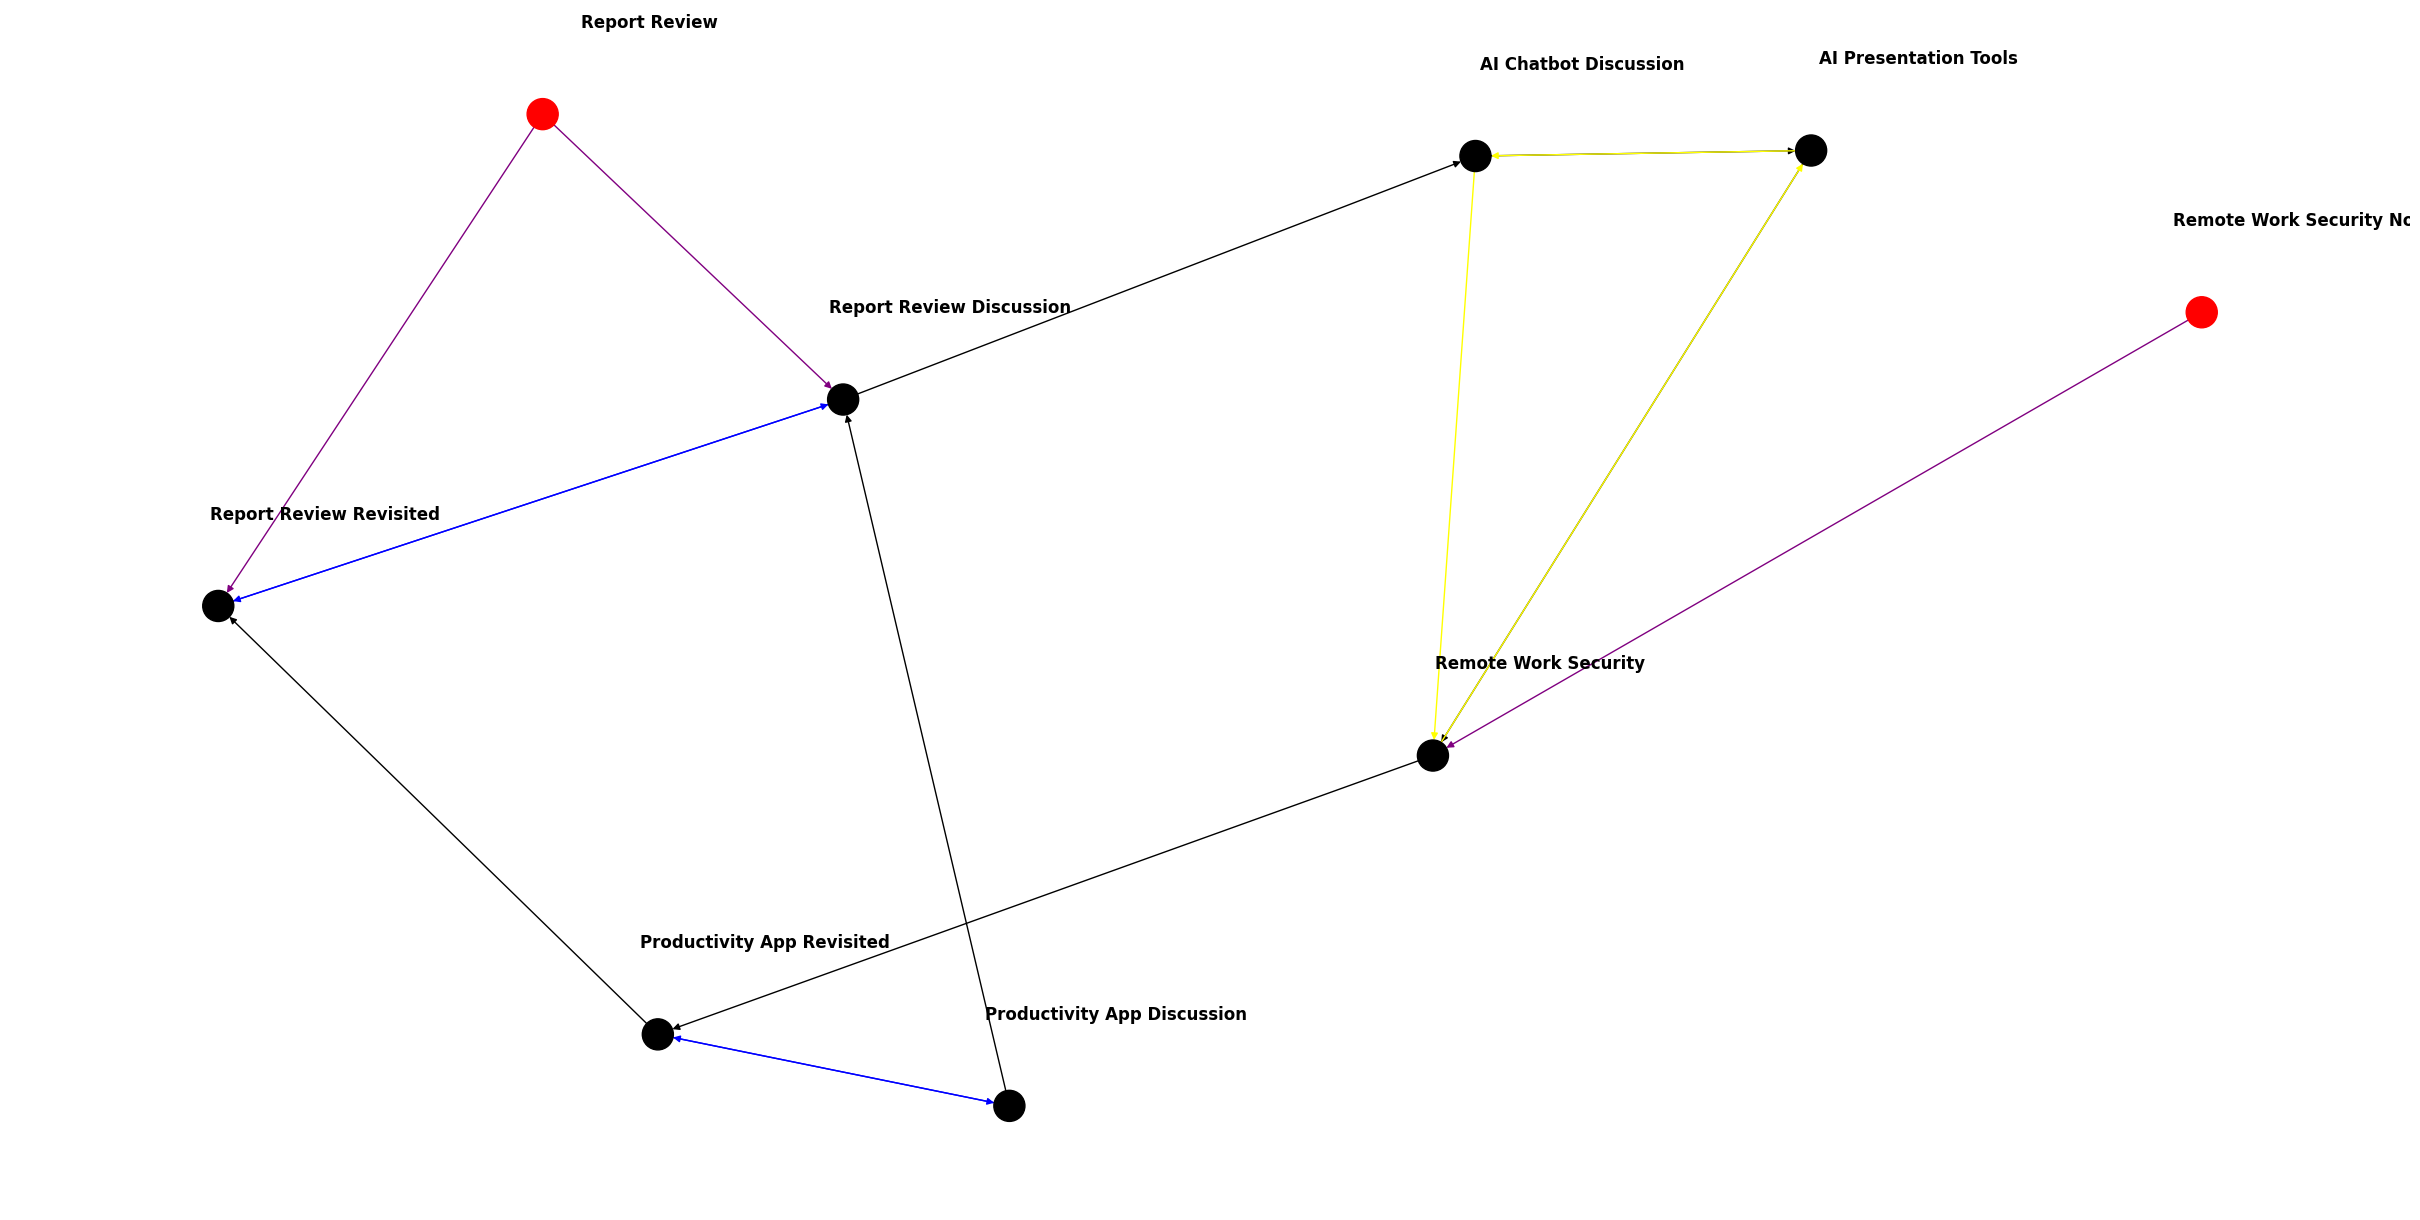

<Figure size 640x480 with 0 Axes>

In [40]:
plt.figure(figsize=(24, 12))
nx.draw(G, pos, node_color=node_colors, edge_color=edge_colors, with_labels=False, node_size=500, arrows=True)
nx.draw_networkx_labels(G, pos_labels, font_color='black', font_weight='bold')

plt.show()
plt.tight_layout()